<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_1_GIACOMO_CARFI_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

# Loading the dataset

https://github.com/Andrew-Wyn/ISPR_HWS/blob/master/MidTerm3_1/ISPR_HW3.ipynb

In [1]:
%%capture
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [2]:
def split_data_and_label(dataset):
  X = dataset.data.float()
  y = dataset.targets
  return X,y

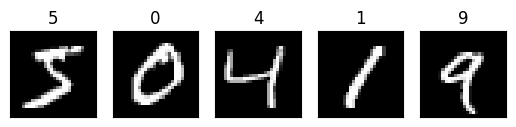

In [3]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

X_train, y_train = split_data_and_label(train_data)
X_test, y_test = split_data_and_label(test_data)

plot_example(X_train, y_train)

In [4]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cpu


# Preparing the dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# resize the dataset - flatten
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

# scaling the dataset
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))
X_test = torch.Tensor(minmaxscaler.transform(X_test))
print("Max:", torch.max(X_train).item())
print("Min:", torch.min(X_train).item())

Max: 1.0
Min: 0.0


The implementation chosen for this assignment is a **denoising autoencoder**, so below a method for adding noise to images is implemented

In [6]:
# add noise to the images
def add_noise(X, mean=0, std=1):
  noisy_imgs = X + torch.randn(X.shape)*std + mean 
  # Clip the images to be between 0 and 1
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  return noisy_imgs

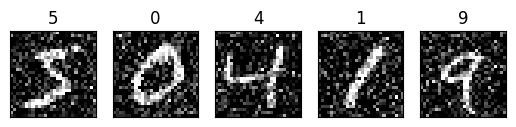

In [7]:
noise_std = 0.3
X_train_noisy = add_noise(X_train[:5], 0, noise_std)
plot_example(X_train_noisy, y_train)

# Utils

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def fit(epochs, model, criterion, X_train, optimizer):
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(X_train, batch_size=20, shuffle=True)
  
  history = []

  for epoch in range(1, epochs+1):
    train_loss=0.0

    for images in train_loader:
      # reset gradient
      optimizer.zero_grad()

      # add noise
      noisy_images = add_noise(images, 0, noise_std)

      #forward pass
      output = model(noisy_images)
      
      loss = criterion(output, images)

      # optimizer step and backward pass
      loss.backward()
      optimizer.step()

      train_loss += loss.item()*images.size(0)
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
    history.append(train_loss)
    
  return history

In [10]:
def evaluate(model, data, criterion):
  X_test_noisy = add_noise(data, 0, noise_std)
  with torch.no_grad():
    output = model(X_test_noisy)
    loss = criterion(output, data) 

  return loss, X_test_noisy, output

In [11]:
def check_results(input, denoised, original, label):
  # show images and their reconstruction
  rows = 3
  columns = 5

  fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 10))
  for i in range(rows):
      for j in range(columns):
          if i==0:
            axes[i, j].imshow(input[j].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(label[j].item(), fontsize=20) 
          if i==1:
            axes[i, j].imshow(denoised[j].reshape(28, 28), cmap='gray')
          if i==2:
            axes[i, j].imshow(original[j].reshape(28, 28), cmap='gray')

          axes[i, j].tick_params(left = False, right = False , labelleft = False,
                  labelbottom = False, bottom = False)
          
  axes[0, 0].set_ylabel("INPUT", fontsize=20)        
  axes[1, 0].set_ylabel("DENOISED", fontsize=20)
  axes[2, 0].set_ylabel("ORIGINAL", fontsize=20)
  
  plt.show()

In [12]:
# counting the number of free params of the model
def count_parameters(model):
    free_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {free_params} free params")

# Autoencoder definition

In [44]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, enc_dim, last_layer=True):
    super(Autoencoder, self).__init__()
    self.last_layer = last_layer
    self.input_dim = input_dim
    self.enc_dim = enc_dim
    # encoder made of one linear layer that maps a vector of size input dim into a vector of size enc_dim
    self.encoder = nn.Linear(input_dim, enc_dim)
    # the decoder will reconstruct the image in the original space
    self.decoder = nn.Linear(enc_dim, input_dim)

    self.enc_activation = nn.ReLU()

    if self.last_layer:
      self.dec_act = nn.Sigmoid()
    else:
      self.dec_act = nn.ReLU()
   
  def encode(self, x):
    x = self.encoder(x)
    x = self.enc_activation(x)
    return x
  
  def decode(self, x):
    x = self.decoder(x)
    x = self.dec_act(x)
    return x

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

In [45]:
criterion = nn.MSELoss()
epochs=10

# Single Layer Autoencoder

In [15]:
model = Autoencoder(X_train.shape[1], 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
count_parameters(model)

The model has 201616 free params


In [16]:
history = fit(epochs, model, criterion, X_train, optimizer)

Epoch: 1 	Training Loss: 0.414570531056573
Epoch: 2 	Training Loss: 0.197280396859472
Epoch: 3 	Training Loss: 0.17557749101271233
Epoch: 4 	Training Loss: 0.1661866417278846
Epoch: 5 	Training Loss: 0.1609704628835122
Epoch: 6 	Training Loss: 0.1583276628361394
Epoch: 7 	Training Loss: 0.15698056320659817
Epoch: 8 	Training Loss: 0.15591326407156886
Epoch: 9 	Training Loss: 0.1555334572152545
Epoch: 10 	Training Loss: 0.15516753489462037


In [17]:
loss, noisy_data, denoised = evaluate(model, X_test, criterion)
print("Single layer AutoEncoder loss:", loss.item())

Single layer AutoEncoder loss: 0.007730334065854549


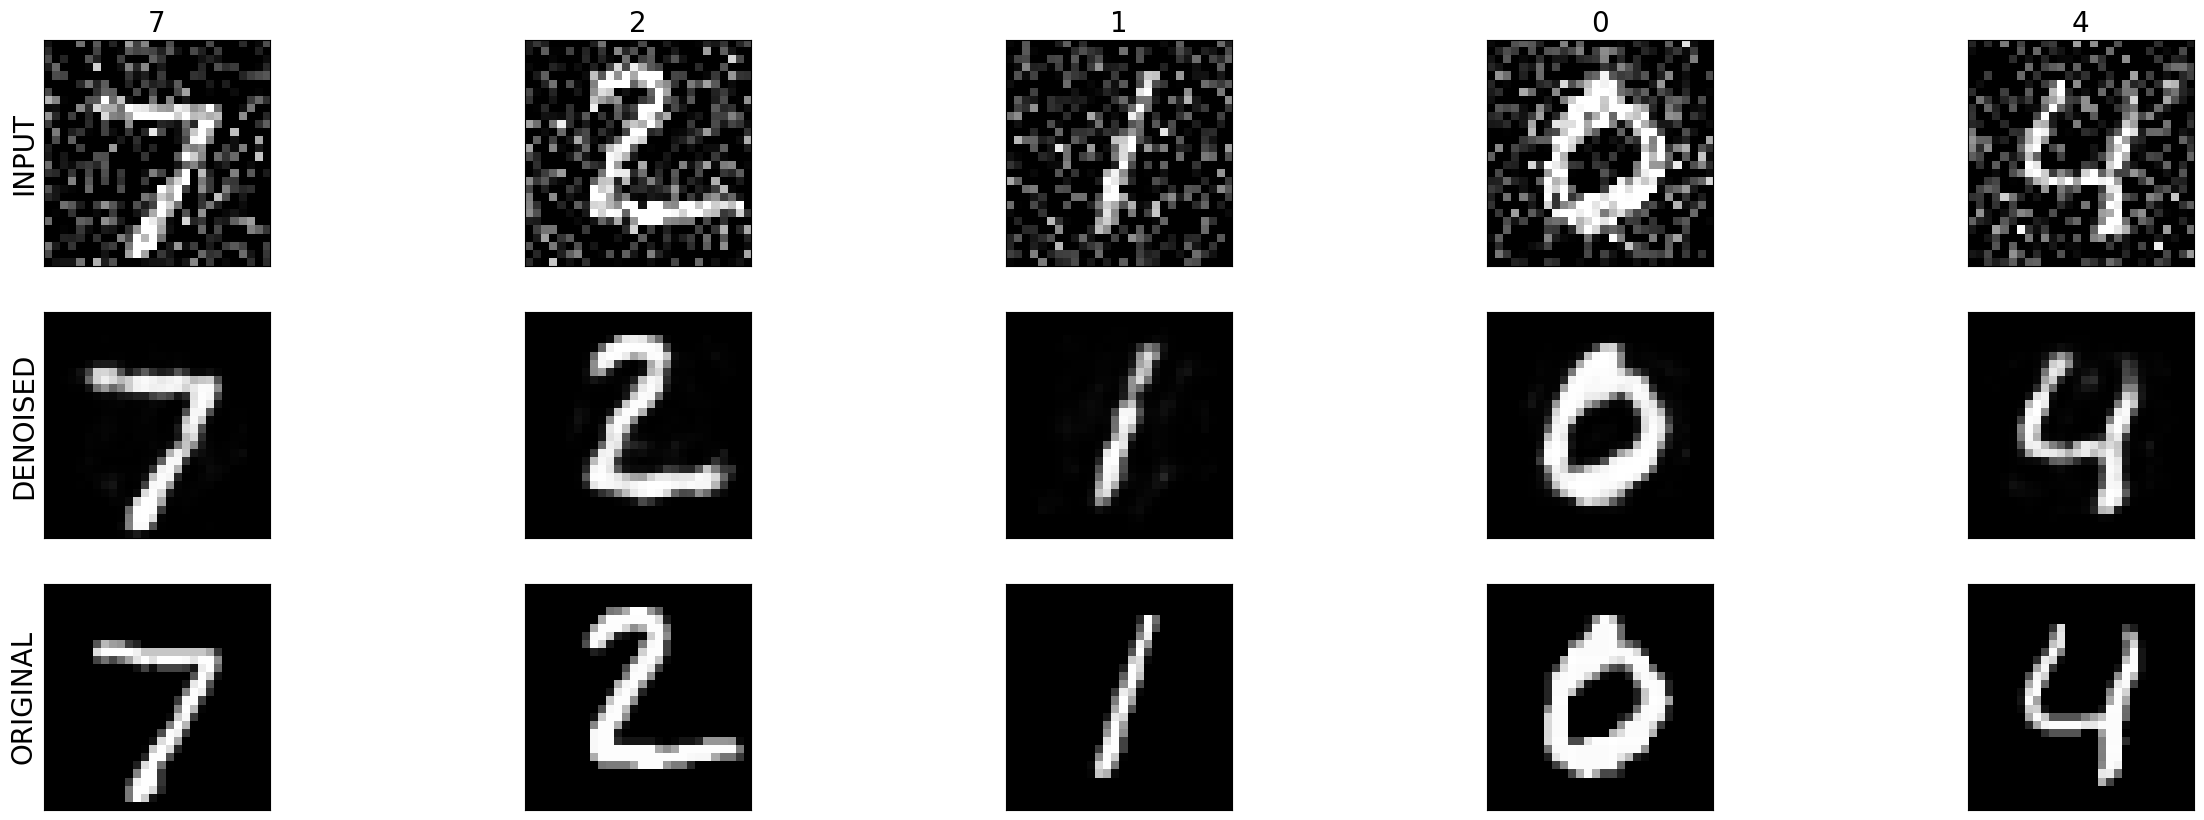

In [18]:
check_results(noisy_data, denoised, X_test, y_test)

# Deep AutoEncoder with only layerwise pretraining

https://www.kaggle.com/code/baogorek/autoencoder-with-greedy-layer-wise-pretraining/notebook

https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

In [52]:
class DeepAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_layers):
    super().__init__()

    self.autoencoders = [Autoencoder(input_dim, hidden_layers[0])]
    hidden_layers.pop()
    for elem in hidden_layers:
      input_dim = elem
      self.autoencoders.append(Autoencoder(input_dim, elem, False))
      

    self.model = nn.ModuleList(self.autoencoders)
  
  def encode(self, x):
    for ae in self.model:
      x = ae.encode(x)
    return x

  def decode(self, x):
    # reverse list of models and decode
    for ae in self.model[::-1]:
      x = ae.decode(x)
    return x

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x



In [53]:
hidden_layers = [128]
deep_ae = DeepAutoEncoder(X_train.shape[1], hidden_layers)
count_parameters(deep_ae)

The model has 201616 free params


In [54]:
data_in = X_train
for ae in deep_ae.model:
  fit(epochs, ae, criterion, data_in, optimizer)

  # create latent rappresentation of data
  # the new encoded data_in will be passed to the data loader in the fit method
  with torch.no_grad():
    data_in = ae.encode(data_in)


Epoch: 1 	Training Loss: 4.640416089892387
Epoch: 2 	Training Loss: 4.640401929914951


KeyboardInterrupt: ignored

# Deep AutoEncoder with Fine Tuning

In [ ]:
history = fit(epochs, deep_ae, criterion, X_train, optimizer)

In [ ]:
loss, noisy_data, denoised = evaluate(deep_ae, X_test, criterion)
print("Deep AutoEncoder loss:", loss.item())

In [ ]:
check_results(noisy_data, denoised, X_test, y_test)